In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import calendar
import datetime as dt
import datetime
import pickle
import azureml.train.automl
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from math import sqrt
from lifelines.utils import k_fold_cross_validation
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

In [1]:
# Load Model
filename = 'Survival_Model_ALL_Data.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [3]:
open_invoices=pd.read_csv('Open_invoices_On_October_30.csv', thousands=",")

In [4]:
open_invoices.head()

,customer_nbr,source_country_code,security_country_code,country_code,invoice_nbr,Invoice_Base_Amount_US,Commited_Days,Payment_Term,Invoice_Category,Count_Paid_Invoices,Count_Delayed_Invoice,Ratio_Delayed_Invoices,Paid_Invoices_amount_US,Dalayed_Paid_Invoices_Amount,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Count_Outstanding_Invoices,Count_Delayed_Outstanding_Invoice,Ratio_Outstanding_Invoices,Outstanding_Invoices_amount,Dalayed_Outstanding_Invoices_Amount,Ratio_Late_Outstanding_Amount,Avg_Days_Late_Outstanding_Invoices_Open,DSO,Delay_Status,industry_name,invoice_date,aging_date,payment_due_date,Payment_Quarter,Count_Prepaid_Invoices,Ratio_Prepaid_Invoices,Invc_creation_month,Invc_commited_date_month,Actual_close_date_Month,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,actual_close_date,ME_Due_Date,ME_Inv_Date,MME_Due_Date,MME_Inv_Date,Invoice_OKS,TM_Invoice,OM_Invoice,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name
0,4972041,0,CA,CA,4503108331,4.938,44,2,0,1090952,939181,0.861,15614426.213,13144671.508,0.842,52.000,28693,28693,1.000,212596.598,212596.598,1.000,19000200.126,983689,4,Telecom and Tech ...,8/18/19,10/1/19,10/1/19,2019Q4,134320,0.123,8,10,12,151771,354897,371794,79933,132557,28693,12/31/12,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2658178CA,0,CA,CA,4503119741,74.018,30,1,0,351934,162565,0.462,522686819.961,325346208.266,0.622,31.000,7025,7025,1.000,9514009.829,9514009.829,1.000,19000983.176,983693,4,Financial ...,8/28/19,8/28/19,9/27/19,2019Q3,181477,0.516,8,9,12,189369,125231,18917,3540,14877,7025,12/31/12,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1631,0,US,US,2828746976,50.220,30,1,0,2108562,2027465,0.962,1211369167.560,1120313202.220,0.925,17.000,2771,2771,1.000,7235209.150,7235209.150,1.000,19001519.758,983680,4,Financial ...,9/10/19,9/10/19,10/10/19,2019Q4,76364,0.036,9,10,12,81097,1867835,74485,29117,56028,2771,12/31/12,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6821595,0,US,US,2825329795,220.720,30,1,0,2126,1551,0.730,536758.820,407313.510,0.759,216.000,414,414,1.000,101269.380,101269.380,1.000,19010163.584,984345,4,Financial ...,11/14/17,11/14/17,12/14/17,2017Q4,547,0.257,11,12,12,575,379,114,115,943,414,12/31/12,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1000IN,0,IN,IN,OMGDPY65223,199.979,30,1,0,20934,20366,0.973,55997449.939,53250075.529,0.951,223.000,3763,3763,1.000,3731601.199,3731601.199,1.000,19000993.314,983661,4,Financial ...,9/29/19,9/29/19,10/29/19,2019Q4,528,0.025,9,10,12,568,1427,1922,1637,15380,3763,12/31/12,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [5]:
open_invoices['payment_due_date']=pd.to_datetime(open_invoices['payment_due_date'])
open_invoices['invoice_date']=pd.to_datetime(open_invoices['invoice_date'], errors='coerce')

In [6]:
open_invoices = open_invoices.loc[(open_invoices['invoice_date'] >= '2018-01-01')]
print(open_invoices.shape)

(791508, 65)


In [7]:
def build_time_features(vector):
    pickup_datetime = vector[0]
    month_num = pickup_datetime.month
    day_of_month = pickup_datetime.day
    day_of_week = pickup_datetime.weekday()

    return pd.Series((month_num, day_of_month, day_of_week))

open_invoices[["month_num_due", "day_of_month_due","day_of_week_due"]] = open_invoices[["payment_due_date"]].apply(build_time_features, axis=1)
open_invoices[["month_num_created", "day_of_month_created","day_of_week_created"]] = open_invoices[["invoice_date"]].apply(build_time_features, axis=1)

#Featurization of Aging Date
open_invoices['aging_date']=pd.to_datetime(open_invoices['aging_date'])
open_invoices[["month_num_age", "day_of_month_age","day_of_week_age"]] = open_invoices[["aging_date"]].apply(build_time_features, axis=1)

In [8]:
test = open_invoices.loc[(open_invoices['security_country_code'] == 'US') | (open_invoices['security_country_code'] == 'CA')]

na=pd.read_csv('North_America_Customers.csv')
na2=na[['customer_nbr', 'Flag']]
na2.rename(columns={'Flag':'Customer_Segment'}, inplace=True)

test=test.merge(na2,how='left', on='customer_nbr')

print(open_invoices.shape)
print(test.shape)

(791508, 74)
(654365, 75)


In [9]:
final_test = test[['security_country_code', 'Invoice_Base_Amount_US', 'Commited_Days', 'Invoice_Category', 
                'Ratio_Delayed_Invoices', 'Ratio_Late_Paid_Amount', 'Avg_Days_Late_Paid_Invoices_Closed', 'industry_name', 
                'Ratio_Prepaid_Invoices',  'Invoice_OKS', 'TM_Invoice', 'OM_Invoice', 'closed_bucket_0', 'closed_bucket_1', 'closed_bucket_2', 'closed_bucket_3', 'closed_bucket_4','Open_60_more',
                'HSR_SCA_Invoice', 'SCA_Invoice', 'SAAS_OKS_Invoice', 'HSR_TM_Invoice', 'HSR_Invoice_OKS', 
                'HSR_OM_Invoice', 'Other_Invoice_Type_Name', 'WCS', 'GSH', 'GSR', 'GSF', 'ISF', 'SIT', 'ISR', 'NON',
       'Other_functional_group_short_name', 'month_num_due', 'day_of_month_due', 'day_of_week_due', 'month_num_created', 
                'day_of_month_created', 'day_of_week_created', 'month_num_age', 'day_of_month_age', 'day_of_week_age', 
                  'Customer_Segment']]

final_test['Invoice_Base_Amount_US'] = pd.to_numeric(final_test['Invoice_Base_Amount_US'])



final_test2 = pd.get_dummies(final_test)
print(final_test.shape)
print(final_test2.shape)

(654365, 44)
(654365, 50)


In [10]:
train =pd.read_csv('Train_Survival_AllData_LessColumns.csv')
train = pd.get_dummies(train)
missing_cols = set( train.columns ) - set( final_test2.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    final_test2[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
final_test2 = final_test2[train.columns]

print(final_test2.shape)

(654365, 52)


In [11]:
#Predicting from the trained model
y_pred=loaded_model.predict_median(final_test2)

In [12]:
#Adding to the dataset
test['Predicted_T2P'] = y_pred
test['Predicted_T2P'] = test['Predicted_T2P'].replace(np.inf, np.nan)
#test2=test.loc[~test['Predicted_T2P'].isin([np.inf, -np.inf])]
test['Predicted_Date'] = pd.to_datetime(test['invoice_date']) + pd.to_timedelta(test['Predicted_T2P'], unit='d')
print(test.shape)
print(test.shape)

(654365, 77)
(654365, 77)


In [13]:
LV_pred = test.loc[test['Customer_Segment'] == 'Lesser Value']
LV_pred=LV_pred.loc[(LV_pred['Predicted_Date']>='2019-10-25') & (LV_pred['Predicted_Date']<='2019-12-05')]
Pred = LV_pred.Invoice_Base_Amount_US.sum()
print(LV_pred.Invoice_Base_Amount_US.sum())

45631449.9995


In [14]:
LV_pred.shape

(34631, 77)

In [15]:
test.to_csv('November_Predictions_All.csv', index=False)

In [63]:
Output_File = test.loc[test['Customer_Segment'] == 'Lesser Value']

In [64]:
Output_File.head()

,customer_nbr,source_country_code,security_country_code,country_code,invoice_nbr,Invoice_Base_Amount_US,Commited_Days,Payment_Term,Invoice_Category,Count_Paid_Invoices,Count_Delayed_Invoice,Ratio_Delayed_Invoices,Paid_Invoices_amount_US,Dalayed_Paid_Invoices_Amount,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Count_Outstanding_Invoices,Count_Delayed_Outstanding_Invoice,Ratio_Outstanding_Invoices,Outstanding_Invoices_amount,Dalayed_Outstanding_Invoices_Amount,Ratio_Late_Outstanding_Amount,Avg_Days_Late_Outstanding_Invoices_Open,DSO,Delay_Status,industry_name,invoice_date,aging_date,payment_due_date,Payment_Quarter,Count_Prepaid_Invoices,Ratio_Prepaid_Invoices,Invc_creation_month,Invc_commited_date_month,Actual_close_date_Month,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,actual_close_date,ME_Due_Date,ME_Inv_Date,MME_Due_Date,MME_Inv_Date,Invoice_OKS,TM_Invoice,OM_Invoice,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,Customer_Segment,Predicted_T2P,Predicted_Date
4,5776494,0,US,US,1102408399,58.640,30,1,0,16693,10880,0.652,15396128.310,12157143.480,0.790,53.000,182,182,1.000,776367.290,776367.290,1.000,19002329.922,983755,4,Retail ...,2019-06-27,2019-06-27,2019-07-27,2019Q3,5789,0.347,6,7,12,5813,6162,2076,778,1864,182,12/31/12,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7,27,5,6,27,3,6,27,3,Lesser Value,57.000,2019-08-23
6,1975584,0,US,US,2826889019,48.460,45,2,0,56420,39195,0.695,5450680.730,3071058.000,0.563,52.000,7017,7017,1.000,297985.670,297985.670,1.000,19007989.379,984054,4,Retail ...,2018-08-17,2018-10-01,2018-10-01,2018Q4,17188,0.305,8,10,12,17225,21261,6503,5263,6168,7017,12/31/12,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10,1,0,8,17,4,10,1,0,Lesser Value,94.000,2018-11-19
7,8140174,0,US,US,6501186435,611.000,60,2,0,312,221,0.708,517600.190,362352.830,0.700,62.000,1,1,1.000,99.000,99.000,1.000,18998284.172,983648,4,Hospitality ...,2019-09-12,2019-09-12,2019-11-11,2019Q4,78,0.250,9,11,12,91,128,38,25,30,1,12/31/12,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11,11,0,9,12,3,9,12,3,Lesser Value,125.000,2020-01-15
9,8481553,0,US,US,2828821981,49.650,43,2,0,75337,66813,0.887,4819849.680,4431223.500,0.919,27.000,738,738,1.000,63160.190,63160.190,1.000,19000752.114,983658,4,Retail ...,2019-09-19,2019-11-01,2019-11-01,2019Q4,8522,0.113,9,11,12,8524,50061,11287,1392,4073,738,12/31/12,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,1,4,9,19,3,11,1,4,Lesser Value,89.000,2019-12-17
13,7434125,0,US,US,100442504,773.380,30,1,0,651,472,0.725,2325801.800,1770357.370,0.761,93.000,27,27,1.000,104463.360,104463.360,1.000,19000854.738,983656,4,Hospitality ...,2019-10-04,2019-10-04,2019-11-03,2019Q4,95,0.146,10,11,12,179,306,17,18,131,27,12/31/12,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,11,3,6,10,4,4,10,4,4,Lesser Value,41.000,2019-11-14


In [67]:
Output_File.to_csv('November_Predictions.csv', index=False)

In [15]:
tr_rows = final_test2.iloc[30:34,:]

In [16]:
tr_rows.reset_index(inplace=True)

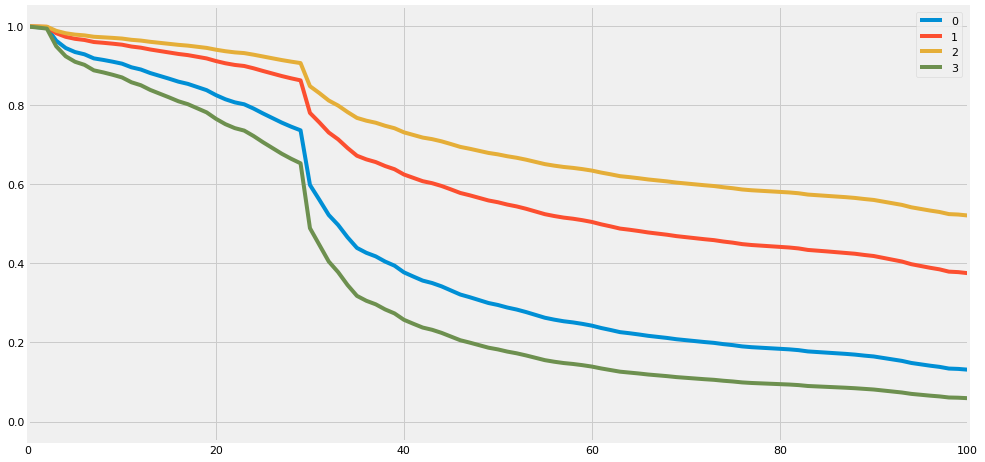

In [17]:
loaded_model.predict_survival_function(tr_rows).plot(xlim = (0,100), figsize = (15,8))

In [169]:
tr_rows

,Invoice_Base_Amount_US,Commited_Days,Invoice_Category,Ratio_Delayed_Invoices,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Ratio_Prepaid_Invoices,Invoice_OKS,TM_Invoice,OM_Invoice,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,DSO2,Paid,security_country_code_CA,security_country_code_US,industry_name_Financial,industry_name_Hospitality,industry_name_Retail,industry_name_Telecom and Tech,industry_name_Travel and Gaming,Customer_Segment_High Value,Customer_Segment_Lesser Value
30,73.156,45,0,0.311,0.305,30.000,0.689,1,0,0,73289,23126,3535,4910,1513,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,1,6,10,17,3,12,1,6,0,0,1,0,1,0,0,0,0,0,1
31,55.250,30,0,0.811,0.799,89.000,0.183,0,1,0,7336,9724,9564,3410,8863,1683,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,11,0,10,12,5,10,12,5,0,0,0,1,1,0,0,0,0,1,0
32,456.810,30,0,0.930,0.911,38.000,0.069,0,0,0,18671,178325,50715,6658,13386,24440,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,8,7,2,7,8,0,7,8,0,0,0,0,1,0,1,0,0,0,1,0
33,7.000,30,0,0.283,0.534,32.000,0.699,1,0,0,1993202,571086,90785,43515,80038,31474,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,9,5,10,10,3,10,10,3,0,0,0,1,1,0,0,0,0,1,0


In [170]:
test.iloc[30:34,:]

,customer_nbr,source_country_code,security_country_code,country_code,invoice_nbr,Invoice_Base_Amount_US,Commited_Days,Payment_Term,Invoice_Category,Count_Paid_Invoices,Count_Delayed_Invoice,Ratio_Delayed_Invoices,Paid_Invoices_amount_US,Dalayed_Paid_Invoices_Amount,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Count_Outstanding_Invoices,Count_Delayed_Outstanding_Invoice,Ratio_Outstanding_Invoices,Outstanding_Invoices_amount,Dalayed_Outstanding_Invoices_Amount,Ratio_Late_Outstanding_Amount,Avg_Days_Late_Outstanding_Invoices_Open,DSO,Delay_Status,industry_name,invoice_date,aging_date,payment_due_date,Payment_Quarter,Count_Prepaid_Invoices,Ratio_Prepaid_Invoices,Invc_creation_month,Invc_commited_date_month,Actual_close_date_Month,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,actual_close_date,ME_Due_Date,ME_Inv_Date,MME_Due_Date,MME_Inv_Date,Invoice_OKS,TM_Invoice,OM_Invoice,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,Customer_Segment,Predicted_T2P,Predicted_Date,ID
30,4570076,0,CA,CA,4503175949,73.156,45,2,0,106373,33084,0.311,3686022.730,1126242.924,0.305,30.000,18,18,1.000,690.474,690.474,1.000,19000192.221,983628,4,Financial ...,2019-10-17,2019-12-01,2019-12-01,2019Q4,73289,0.689,10,12,12,73289,23126,3535,4910,1513,18,12/31/12,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,1,6,10,17,3,12,1,6,Lesser Value,33.000,2019-11-19,4570076_4503175949_CA
31,27854,0,US,US,1102474811,55.250,30,1,0,38897,31561,0.811,117295207.370,93711843.720,0.799,89.000,1683,1683,1.000,1939480.030,1939480.030,1.000,19002549.009,983648,4,Financial ...,2019-10-12,2019-10-12,2019-11-11,2019Q4,7129,0.183,10,11,12,7336,9724,9564,3410,8863,1683,12/31/12,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,11,0,10,12,5,10,12,5,High Value,61.000,2019-12-12,27854_1102474811_US
32,7430837,0,US,US,200380385,456.810,30,1,0,267755,249084,0.930,212355668.850,193551125.590,0.911,38.000,24440,24440,1.000,16265111.750,16265111.750,1.000,19000442.547,983744,4,Hospitality ...,2019-07-08,2019-07-08,2019-08-07,2019Q3,18340,0.069,7,8,12,18671,178325,50715,6658,13386,24440,12/31/12,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,8,7,2,7,8,0,7,8,0,High Value,114.000,2019-10-30,7430837_200380385_US
33,28163,0,US,US,2828896935,7.000,30,1,0,2778626,785424,0.283,970991363.200,518146131.550,0.534,32.000,31474,31474,1.000,15033896.890,15033896.890,1.000,19000505.525,983650,4,Financial ...,2019-10-10,2019-10-10,2019-11-09,2019Q4,1940866,0.699,10,11,12,1993202,571086,90785,43515,80038,31474,12/31/12,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,9,5,10,10,3,10,10,3,High Value,30.000,2019-11-09,28163_2828896935_US


In [236]:
final_test2.loc[(final_test2['industry_name_Financial                                         ']==1) & (final_test2['Customer_Segment_Lesser Value']==1)] 

,Invoice_Base_Amount_US,Commited_Days,Invoice_Category,Ratio_Delayed_Invoices,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Ratio_Prepaid_Invoices,Invoice_OKS,TM_Invoice,OM_Invoice,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,DSO2,Paid,security_country_code_CA,security_country_code_US,industry_name_Financial,industry_name_Hospitality,industry_name_Retail,industry_name_Telecom and Tech,industry_name_Travel and Gaming,Customer_Segment_High Value,Customer_Segment_Lesser Value
29,54.871,45,0,0.311,0.305,30.000,0.689,1,0,0,73289,23126,3535,4910,1513,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,1,4,9,17,1,11,1,4,0,0,1,0,1,0,0,0,0,0,1
30,73.156,45,0,0.311,0.305,30.000,0.689,1,0,0,73289,23126,3535,4910,1513,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,1,6,10,17,3,12,1,6,0,0,1,0,1,0,0,0,0,0,1
89,242.280,30,0,0.730,0.759,216.000,0.257,1,0,0,575,379,114,115,943,414,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,21,4,5,22,2,6,1,5,0,0,0,1,1,0,0,0,0,0,1
119,102.840,30,0,0.915,0.913,79.000,0.085,0,1,0,1450,3043,3644,3857,4989,5047,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,24,4,4,24,2,4,24,2,0,0,0,1,1,0,0,0,0,0,1
126,4.571,45,0,0.311,0.305,30.000,0.689,1,0,0,73289,23126,3535,4910,1513,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,1,4,9,17,1,11,1,4,0,0,1,0,1,0,0,0,0,0,1
144,6721.950,30,1,0.826,0.663,118.000,0.168,1,0,0,150,218,138,96,260,49,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,25,6,7,26,4,7,26,4,0,0,0,1,1,0,0,0,0,0,1
194,102.840,30,0,0.915,0.913,79.000,0.085,0,1,0,1450,3043,3644,3857,4989,5047,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,5,6,4,5,4,4,5,4,0,0,0,1,1,0,0,0,0,0,1
202,102.840,30,0,0.915,0.913,79.000,0.085,0,1,0,1450,3043,3644,3857,4989,5047,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,25,0,1,26,5,1,26,5,0,0,0,1,1,0,0,0,0,0,1
216,6453.830,30,0,0.669,0.595,155.000,0.327,0,0,1,81,48,22,4,90,53,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,11,6,2,10,7,0,10,7,0,0,0,0,1,1,0,0,0,0,0,1
245,664.760,30,0,0.700,0.447,123.000,0.292,1,0,0,160,137,32,14,191,69,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,19,3,8,20,1,8,20,1,0,0,0,1,1,0,0,0,0,0,1


In [210]:
final_test2.columns

Index(['Invoice_Base_Amount_US', 'Commited_Days', 'Invoice_Category', 'Ratio_Delayed_Invoices', 'Ratio_Late_Paid_Amount', 'Avg_Days_Late_Paid_Invoices_Closed', 'Ratio_Prepaid_Invoices', 'Invoice_OKS', 'TM_Invoice', 'OM_Invoice', 'closed_bucket_0', 'closed_bucket_1', 'closed_bucket_2', 'closed_bucket_3', 'closed_bucket_4', 'Open_60_more', 'HSR_SCA_Invoice', 'SCA_Invoice', 'SAAS_OKS_Invoice', 'HSR_TM_Invoice', 'HSR_Invoice_OKS', 'HSR_OM_Invoice', 'Other_Invoice_Type_Name', 'WCS', 'GSH', 'GSR', 'GSF', 'ISF', 'SIT', 'ISR', 'NON', 'Other_functional_group_short_name', 'month_num_due', 'day_of_month_due', 'day_of_week_due', 'month_num_created', 'day_of_month_created', 'day_of_week_created', 'month_num_age', 'day_of_month_age', 'day_of_week_age', 'DSO2', 'Paid', 'security_country_code_CA', 'security_country_code_US', 'industry_name_Financial                                         ', 'industry_name_Hospitality                                       ',
       'industry_name_Retail               

In [18]:
financial=final_test2.iloc[29:30,:]
retail=final_test2.iloc[4:5,:]
hosp=final_test2.iloc[7:8,:]

In [19]:
x = financial.append([retail,hosp])

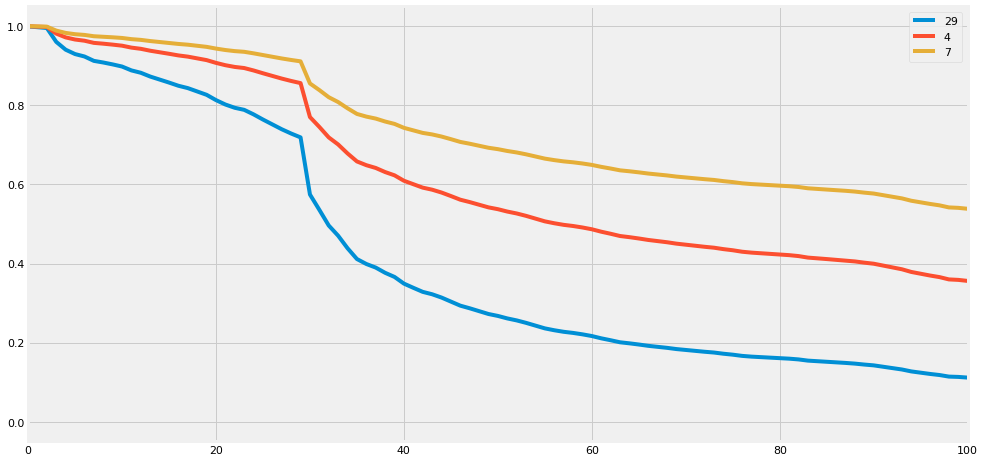

In [20]:
loaded_model.predict_survival_function(x).plot(xlim = (0,100), figsize = (15,8))

In [21]:
a=loaded_model.predict_survival_function(x)

In [22]:
b=a.rename(columns={29:"Financial",4:"Retail",7:"Hospitality"})

In [23]:
b.head()

,Financial,Retail,Hospitality
0.000,0.999,1.000,1.000
1.000,0.997,0.999,0.999
2.000,0.995,0.998,0.999
3.000,0.960,0.981,0.989
4.000,0.940,0.971,0.983


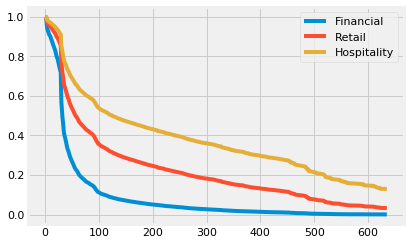

In [24]:
b.plot()

In [25]:
b.to_csv('Survival Probabilities.csv')

In [262]:
x

,Invoice_Base_Amount_US,Commited_Days,Invoice_Category,Ratio_Delayed_Invoices,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Ratio_Prepaid_Invoices,Invoice_OKS,TM_Invoice,OM_Invoice,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,DSO2,Paid,security_country_code_CA,security_country_code_US,industry_name_Financial,industry_name_Hospitality,industry_name_Retail,industry_name_Telecom and Tech,industry_name_Travel and Gaming,Customer_Segment_High Value,Customer_Segment_Lesser Value
29,54.871,45,0,0.311,0.305,30.000,0.689,1,0,0,73289,23126,3535,4910,1513,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,1,4,9,17,1,11,1,4,0,0,1,0,1,0,0,0,0,0,1
4,58.640,30,0,0.652,0.790,53.000,0.347,0,1,0,5813,6162,2076,778,1864,182,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7,27,5,6,27,3,6,27,3,0,0,0,1,0,0,1,0,0,0,1
7,611.000,60,0,0.708,0.700,62.000,0.250,0,0,0,91,128,38,25,30,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11,11,0,9,12,3,9,12,3,0,0,0,1,0,1,0,0,0,0,1


In [271]:
test.iloc[7:8,:]

,customer_nbr,source_country_code,security_country_code,country_code,invoice_nbr,Invoice_Base_Amount_US,Commited_Days,Payment_Term,Invoice_Category,Count_Paid_Invoices,Count_Delayed_Invoice,Ratio_Delayed_Invoices,Paid_Invoices_amount_US,Dalayed_Paid_Invoices_Amount,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Count_Outstanding_Invoices,Count_Delayed_Outstanding_Invoice,Ratio_Outstanding_Invoices,Outstanding_Invoices_amount,Dalayed_Outstanding_Invoices_Amount,Ratio_Late_Outstanding_Amount,Avg_Days_Late_Outstanding_Invoices_Open,DSO,Delay_Status,industry_name,invoice_date,aging_date,payment_due_date,Payment_Quarter,Count_Prepaid_Invoices,Ratio_Prepaid_Invoices,Invc_creation_month,Invc_commited_date_month,Actual_close_date_Month,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,actual_close_date,ME_Due_Date,ME_Inv_Date,MME_Due_Date,MME_Inv_Date,Invoice_OKS,TM_Invoice,OM_Invoice,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,Customer_Segment,Predicted_T2P,Predicted_Date,ID
7,8140174,0,US,US,6501186435,611.000,60,2,0,312,221,0.708,517600.190,362352.830,0.700,62.000,1,1,1.000,99.000,99.000,1.000,18998284.172,983648,4,Hospitality ...,2019-09-12,2019-09-12,2019-11-11,2019Q4,78,0.250,9,11,12,91,128,38,25,30,1,12/31/12,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11,11,0,9,12,3,9,12,3,Lesser Value,125.000,2020-01-15,8140174_6501186435_US


### Actual Closed in November

In [82]:
test['ID'] = test['customer_nbr'].astype(str) + "_" + test['invoice_nbr'].astype(str) + "_" + test['security_country_code'].astype(str)

In [86]:
nov_closed = pd.read_csv('actual_closed_invoice_nov_alldetail.csv')

In [87]:
nov_closed.shape

(269014, 8)

In [88]:
nov_closed.head()

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7
0,2828808029,167260,US,9/17/2019,11/1/2019,11/29/2019,115.660,nan
1,2828833916,43610,US,9/27/2019,10/27/2019,11/5/2019,77.220,nan
2,2828880408,28163,US,10/10/2019,11/9/2019,11/29/2019,106.770,nan
3,6006988051,28152,US,9/30/2019,10/30/2019,11/4/2019,893.540,nan
4,200472344,7430837,US,10/23/2019,11/22/2019,11/29/2019,609.120,nan


In [89]:
nov_closed['ID'] = nov_closed['customer_nbr'].astype(str) + "_" + nov_closed['invoice_nbr'].astype(str) + "_" + nov_closed['security_country_code'].astype(str)
print(nov_closed.shape)

(269014, 9)


In [90]:
nov_closed['actual_close_date'] = pd.to_datetime(nov_closed['actual_close_date'])

In [91]:
nov_closed['actual_close_date'].describe()

count                  269014
unique                     30
top       2019-11-29 00:00:00
freq                    60494
first     2019-11-01 00:00:00
last      2019-11-30 00:00:00
Name: actual_close_date, dtype: object

In [92]:
nov_closed['invoice_date'] = pd.to_datetime(nov_closed['invoice_date'])
nov_closed['invoice_date'].describe()

count                  269014
unique                    862
top       2019-10-10 00:00:00
freq                    54660
first     2003-07-21 00:00:00
last      2019-11-30 00:00:00
Name: invoice_date, dtype: object

In [93]:
na=pd.read_csv('North_America_Customers.csv')
na2=na[['customer_nbr', 'Flag']]
na2.rename(columns={'Flag':'Customer_Segment'}, inplace=True)

nov_closed=nov_closed.merge(na2,how='left', on='customer_nbr')

In [94]:
nov_closed.head()

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7,ID,Customer_Segment
0,2828808029,167260,US,2019-09-17,11/1/2019,2019-11-29,115.660,nan,167260_2828808029_US,High Value
1,2828833916,43610,US,2019-09-27,10/27/2019,2019-11-05,77.220,nan,43610_2828833916_US,High Value
2,2828880408,28163,US,2019-10-10,11/9/2019,2019-11-29,106.770,nan,28163_2828880408_US,High Value
3,6006988051,28152,US,2019-09-30,10/30/2019,2019-11-04,893.540,nan,28152_6006988051_US,High Value
4,200472344,7430837,US,2019-10-23,11/22/2019,2019-11-29,609.120,nan,7430837_200472344_US,High Value


In [95]:
nov_closed2 = nov_closed.loc[(nov_closed['security_country_code'] == 'US') | (nov_closed['security_country_code'] == 'CA')]
nov_closed3 = nov_closed2.loc[nov_closed2['Customer_Segment'] == 'Lesser Value']

In [100]:
nov_closed4 = nov_closed3.loc[(nov_closed3['invoice_date'] < '2019-11-01') & (nov_closed3['invoice_date'] > '2018-01-01')]

In [101]:
nov_closed4.head()

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7,ID,Customer_Segment
15,1102443409,18660,US,2019-08-23,9/22/2019,2019-11-19,758.120,nan,18660_1102443409_US,Lesser Value
25,2828637876,2494353,US,2019-08-15,11/13/2019,2019-11-14,137.480,nan,2494353_2828637876_US,Lesser Value
35,100442618,7428142,US,2019-10-05,11/4/2019,2019-11-12,32.250,nan,7428142_100442618_US,Lesser Value
38,1102449967,27352,US,2019-08-29,9/28/2019,2019-11-04,89.120,nan,27352_1102449967_US,Lesser Value
40,2828651801,32303,US,2019-08-17,10/1/2019,2019-11-04,42.900,nan,32303_2828651801_US,Lesser Value


In [102]:
nov_closed4.amount.sum()

60606186.330000006

In [104]:
60606186.330000006 - 45631449.9995

14974736.330500007

In [107]:
nov_closed4.shape

(56631, 10)

In [118]:
### Checking if all the invoices which are collected were actually predicted upon by the model

In [108]:
tst = nov_closed4[~nov_closed4.ID.isin(test.ID)]

In [111]:
tst.shape

(18711, 10)

In [110]:
test.loc[test['ID']== '9518640_6501227621_US']

,customer_nbr,source_country_code,security_country_code,country_code,invoice_nbr,Invoice_Base_Amount_US,Commited_Days,Payment_Term,Invoice_Category,Count_Paid_Invoices,Count_Delayed_Invoice,Ratio_Delayed_Invoices,Paid_Invoices_amount_US,Dalayed_Paid_Invoices_Amount,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Count_Outstanding_Invoices,Count_Delayed_Outstanding_Invoice,Ratio_Outstanding_Invoices,Outstanding_Invoices_amount,Dalayed_Outstanding_Invoices_Amount,Ratio_Late_Outstanding_Amount,Avg_Days_Late_Outstanding_Invoices_Open,DSO,Delay_Status,industry_name,invoice_date,aging_date,payment_due_date,Payment_Quarter,Count_Prepaid_Invoices,Ratio_Prepaid_Invoices,Invc_creation_month,Invc_commited_date_month,Actual_close_date_Month,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,actual_close_date,ME_Due_Date,ME_Inv_Date,MME_Due_Date,MME_Inv_Date,Invoice_OKS,TM_Invoice,OM_Invoice,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,Customer_Segment,Predicted_T2P,Predicted_Date,ID


In [113]:
open_invoices['ID'] = open_invoices['customer_nbr'].astype(str) + "_" + open_invoices['invoice_nbr'].astype(str) + "_" + open_invoices['security_country_code'].astype(str)

In [114]:
open_invoices.loc[open_invoices['ID']== '9518640_6501227621_US']

,customer_nbr,source_country_code,security_country_code,country_code,invoice_nbr,Invoice_Base_Amount_US,Commited_Days,Payment_Term,Invoice_Category,Count_Paid_Invoices,Count_Delayed_Invoice,Ratio_Delayed_Invoices,Paid_Invoices_amount_US,Dalayed_Paid_Invoices_Amount,Ratio_Late_Paid_Amount,Avg_Days_Late_Paid_Invoices_Closed,Count_Outstanding_Invoices,Count_Delayed_Outstanding_Invoice,Ratio_Outstanding_Invoices,Outstanding_Invoices_amount,Dalayed_Outstanding_Invoices_Amount,Ratio_Late_Outstanding_Amount,Avg_Days_Late_Outstanding_Invoices_Open,DSO,Delay_Status,industry_name,invoice_date,aging_date,payment_due_date,Payment_Quarter,Count_Prepaid_Invoices,Ratio_Prepaid_Invoices,Invc_creation_month,Invc_commited_date_month,Actual_close_date_Month,closed_bucket_0,closed_bucket_1,closed_bucket_2,closed_bucket_3,closed_bucket_4,Open_60_more,actual_close_date,ME_Due_Date,ME_Inv_Date,MME_Due_Date,MME_Inv_Date,Invoice_OKS,TM_Invoice,OM_Invoice,HSR_SCA_Invoice,SCA_Invoice,SAAS_OKS_Invoice,HSR_TM_Invoice,HSR_Invoice_OKS,HSR_OM_Invoice,Other_Invoice_Type_Name,WCS,GSH,GSR,GSF,ISF,SIT,ISR,NON,Other_functional_group_short_name,month_num_due,day_of_month_due,day_of_week_due,month_num_created,day_of_month_created,day_of_week_created,month_num_age,day_of_month_age,day_of_week_age,ID


In [115]:
common = nov_closed4[nov_closed4.ID.isin(test.ID)]

In [116]:
common.amount.sum()

46083181.22

In [126]:
tst.drop(columns=['Unnamed: 7'], inplace=True)

In [127]:
tst.to_csv('Records_Missing_OpenNov.csv', index=False)

In [128]:
tst.head()

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,ID,Customer_Segment
45,90078563,3888843CA,CA,2019-10-12,11/11/2019,2019-11-08,355.950,3888843CA_90078563_CA,Lesser Value
49,6501227621,9518640,US,2019-10-10,11/9/2019,2019-11-11,79.950,9518640_6501227621_US,Lesser Value
60,6501233435,10005354,US,2019-10-10,11/9/2019,2019-11-11,145.000,10005354_6501233435_US,Lesser Value
75,6501217859,9200755,US,2019-10-10,11/9/2019,2019-11-11,488.540,9200755_6501217859_US,Lesser Value
98,6501229889,10006190,US,2019-10-10,11/9/2019,2019-11-11,95.000,10006190_6501229889_US,Lesser Value


In [131]:
tst.shape

(18711, 9)

In [133]:
nov_closed5=nov_closed4[~nov_closed4.ID.isin(tst.ID)]

In [134]:
nov_closed5.amount.sum()

46083181.22

In [172]:
nov_closed4.loc[nov_closed4['invoice_nbr']=='4503175949']

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7,ID,Customer_Segment
21115,4503175949,4570076,CA,2019-10-17,12/1/2019,2019-11-27,95.860,nan,4570076_4503175949_CA,Lesser Value


In [185]:
common.head()

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7,ID,Customer_Segment
15,1102443409,18660,US,2019-08-23,9/22/2019,2019-11-19,758.120,nan,18660_1102443409_US,Lesser Value
25,2828637876,2494353,US,2019-08-15,11/13/2019,2019-11-14,137.480,nan,2494353_2828637876_US,Lesser Value
35,100442618,7428142,US,2019-10-05,11/4/2019,2019-11-12,32.250,nan,7428142_100442618_US,Lesser Value
38,1102449967,27352,US,2019-08-29,9/28/2019,2019-11-04,89.120,nan,27352_1102449967_US,Lesser Value
40,2828651801,32303,US,2019-08-17,10/1/2019,2019-11-04,42.900,nan,32303_2828651801_US,Lesser Value


In [188]:
industry = test[['ID','industry_name']]

In [189]:
common2 = common.merge(industry, how='inner', on='ID')

In [191]:
common2.groupby('industry_name').sum()['amount']

industry_name
Financial                                            17911038.180
Hospitality                                          13691884.160
Retail                                               11309869.540
Telecom and Tech                                      3051176.140
Travel and Gaming                                      119213.200
Name: amount, dtype: float64

In [193]:
LV_pred.groupby('industry_name').sum()['Invoice_Base_Amount_US']

industry_name
Financial                                            16119329.477
Hospitality                                          19597263.134
Retail                                                6736827.917
Telecom and Tech                                      2949103.903
Travel and Gaming                                      228925.569
Name: Invoice_Base_Amount_US, dtype: float64

In [198]:
a=common2.amount.sum()

In [199]:
b=LV_pred.Invoice_Base_Amount_US.sum()

In [200]:
a-b

451731.2204999998

In [270]:
nov_closed4.loc[nov_closed4['ID'] == '5776494_1102408399_US']

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7,ID,Customer_Segment


In [286]:
cl = pd.read_csv('actual_closed_invoice_nov_alldetail.csv')
cl.amount.sum()

23940955605.260002

In [287]:
cl['invoice_date'] = pd.to_datetime(cl['invoice_date'])

In [288]:
step1 = cl.loc[(cl['invoice_date'] < '2019-11-01') & (cl['invoice_date'] > '2018-01-01')]
step1.amount.sum()

22393889196.65

In [289]:
step2 = step1.loc[(step1['security_country_code']=='US') | (step1['security_country_code']=='CA')]
step2.amount.sum()

273856602.14

In [295]:
step1.groupby('security_country_code').sum()['amount'].sort_values(ascending=False)

security_country_code
ID   12409159988.760
JP    3795033571.280
IN    1452617228.000
CO    1394283190.370
CL    1256101356.950
KR     703490974.660
AR     251997651.000
US     233921732.950
PH     233702937.880
XH      94874684.400
MX      82277852.080
RU      77236456.180
TH      60995610.420
TW      56570997.000
CA      39934869.190
GB      32378571.560
CN      21039191.630
Y1      15605645.790
AU      15321909.080
ES      15098909.970
TR      14712686.670
FR      13364812.110
DK      12139558.190
IT      11210329.880
MY      11146940.030
CZ      10471041.690
DE      10165458.840
XS       8431977.800
HK       8325804.950
SG       8067688.220
IL       6844570.450
XC       6188436.710
NZ       5680305.350
SE       4426402.290
PL       4229291.130
XW       3688078.590
CH       2781223.670
NL       2499724.680
DO       1963902.070
PE       1438019.900
AT       1199709.520
XM        849374.100
BE        666451.920
NO        638989.740
PT        586382.680
PR        494775.820
XD         3

In [290]:
na=pd.read_csv('North_America_Customers.csv')
na2=na[['customer_nbr', 'Flag']]
na2.rename(columns={'Flag':'Customer_Segment'}, inplace=True)

step2=step2.merge(na2,how='left', on='customer_nbr')

In [292]:
step2.head()

,invoice_nbr,customer_nbr,security_country_code,invoice_date,payment_due_date,actual_close_date,amount,Unnamed: 7,Customer_Segment
0,2828808029,167260,US,2019-09-17,11/1/2019,11/29/2019,115.660,nan,High Value
1,2828833916,43610,US,2019-09-27,10/27/2019,11/5/2019,77.220,nan,High Value
2,2828880408,28163,US,2019-10-10,11/9/2019,11/29/2019,106.770,nan,High Value
3,6006988051,28152,US,2019-09-30,10/30/2019,11/4/2019,893.540,nan,High Value
4,200472344,7430837,US,2019-10-23,11/22/2019,11/29/2019,609.120,nan,High Value


In [294]:
step3 = step2.loc[step2['Customer_Segment']=='Lesser Value']
step3.amount.sum()

60606186.330000006

In [26]:
#Reading the closed data and merging them together
q1=pd.read_csv('train_2019q1.csv')
q2=pd.read_csv('train_2019q2.csv')
q3=pd.read_csv('train_2019q3.csv')
q4=pd.read_csv('train_2018q4.csv')

df=q4.append([q1,q2,q3])
print(df.shape)

(3274451, 65)


In [27]:
df.customer_nbr.nunique()

44312

In [29]:
df_NA = df.loc[(df['security_country_code'] == 'US') | (df['security_country_code'] == 'CA') ]

In [30]:
df_NA.customer_nbr.nunique()

36784